# Detecting layered surfaces
*Authors: Niels Jeppesen (niejep@dtu.dk), Vedrana Andersen Dahl (vand@dtu.dk)*

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vedranaa/teaching-notebooks/blob/main/Surfaces_Detect_Layers.ipynb)

This notebook is partly based on the notebook serving as an example for the use of [slgbuilder package](https://github.com/Skielex/slgbuilder) which allows for building and solving [Sparse Layered Graphs](https://openaccess.thecvf.com/content_CVPR_2020/papers/Jeppesen_Sparse_Layered_Graphs_for_Multi-Object_Segmentation_CVPR_2020_paper.pdf), an extension of ordered multi-column graph structure by [Li et al](https://doi.org/10.1109/TPAMI.2006.19). 


Start by installing slgbuilder. This takes a little bit of time, but only needs to be done once per session.


In [ ]:
!pip install slgbuilder -q

     |████████████████████████████████| 89 kB 4.0 MB/s 
     |████████████████████████████████| 112 kB 31.1 MB/s 


Load modules for working with and showing images.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## A small example
Test `slgbuilder` on a very very small image to confirm that it does find the optimal surface given smoothness constrain.

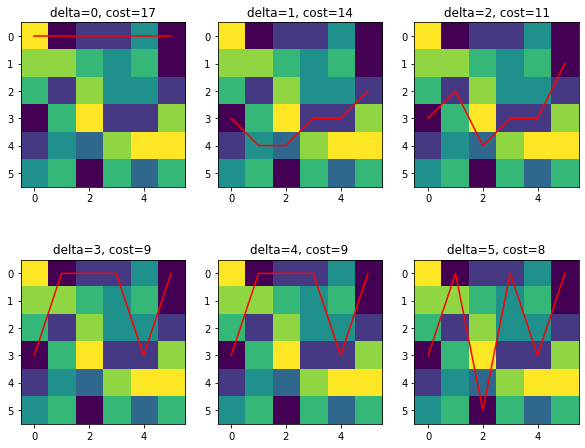

In [ ]:
from slgbuilder import GraphObject, MaxflowBuilder

I = np.array([[7,1,2,2,4,1],
     [6,6,5,4,5,1],
     [5,2,6,4,4,2],
     [1,5,7,2,2,6],
     [2,4,3,6,7,7],
     [4,5,1,5,3,5]]).astype(np.int32)

fig, ax = plt.subplots(2,3, figsize=(10, 8))
ax = ax.ravel()

for i in range(6):
    ax[i].imshow(I)
    
    delta = i
    
    layer = GraphObject(I)
    helper = MaxflowBuilder()
    helper.add_object(layer)
    helper.add_layered_boundary_cost()
    helper.add_layered_smoothness(delta=delta, wrap=False)
    
    helper.solve()
    segmentation = helper.what_segments(layer)
        
    segmentation_line = segmentation.sum(axis=0) - 1
    cost = (I[segmentation_line, np.arange(segmentation.shape[1])]).sum()
    
    ax[i].imshow(I)
    ax[i].plot(segmentation_line, 'r')
    ax[i].set_title(f'delta={delta}, cost={cost}')



## Detect one surface (curve) in an image

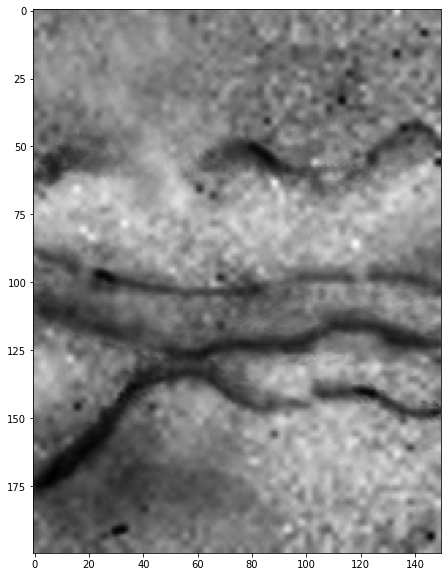

In [ ]:
# Load and show image.
import urllib.request
import skimage.io
url = 'https://qim.compute.dtu.dk/data-repository/demo_data/layers.png'
image = skimage.io.imread(url).astype(np.int32)
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')
plt.show()

Let's create an object that represent the layer we're trying a segment. Here we are only segmenting one layer. The image data is passed directly to the ```GraphObject```. By default, it assumes data is structured on a regular index grid.

In [ ]:
layer_1 = GraphObject(image)

Next we create the `MaxflowBuilder` and add the layer. Then we add layered cost and smoothness. Edges are added automatically when calling `add_layered_boundary_cost` and `add_layered_smoothness`. By default these edges are added for all object previously added to the `MaxflowBuilder`. However, it is possible to add the edges for specific object only, by passing a list of objects to the function. The graph structure is based on [Li et al](https://doi.org/10.1109/TPAMI.2006.19).

In [ ]:
helper = MaxflowBuilder()
helper.add_object(layer_1)
helper.add_layered_boundary_cost()
helper.add_layered_smoothness(delta=1, wrap=False)

The graph is cut using the [Maxflow](https://github.com/Skielex/maxflow) algorithm to get the maximum flow/minimum cut. This algorithm will find the global optimal solution to the binary segmentation problem. 

In [ ]:
flow = helper.solve()
print('Maximum flow/minimum energy:', flow)

Maximum flow/minimum energy: 113831


Get segmentation for layer 1 and display it.

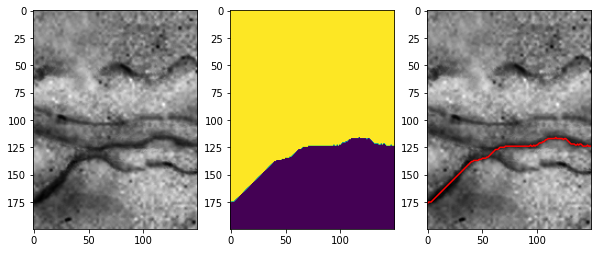

In [ ]:
segmentation = helper.what_segments(layer_1)
segmentation_line = segmentation.sum(axis=0)

# Draw results.
plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 3, 1)
ax.imshow(image, cmap='gray')
ax = plt.subplot(1, 3, 2)
ax.imshow(segmentation)
ax = plt.subplot(1, 3, 3)
ax.imshow(image, cmap='gray')
ax.plot(segmentation_line, 'r')
plt.show()

## Detect multiple surfaces

This time we will create four objects, as we want to segment four different layers. Although our graph cut is still binary, we will create the graph so that we get a multi-label segmentation.

In [ ]:
layers = []
for i in range(4):
    layers.append(GraphObject(image))

We create the ```MaxflowBuilder``` and add all layers to the graph. We then add boundary costs and smoothness as before. This time we specify the smoothness (```delta```) to allow less smooth surfaces than before (default: ```delta = 1```).

In [ ]:
helper = MaxflowBuilder()
helper.add_objects(layers)
helper.add_layered_boundary_cost()
helper.add_layered_smoothness(delta=2, wrap=False)

We've added the layers to the graph, but because they all are based on the same data, and there are no interaction contraints between the layers, they would all result in the exact same segmentation. This is *not* what we want.
We want the layers to be separated by a certain distance. Luckily, [Li et al](https://doi.org/10.1109/TPAMI.2006.19). describe how to enforce a minimum distance between the layers. This technique has been implemented in ```add_layered_containment```, which takes an *outer* and an *inner* ```GraphObject``` and lets you specify both a minimum and maximum distance/margin between them. In this case we will only specify a minimum margin.

Let's add the interactions and call ```maxflow```.

In [ ]:
for i in range(len(layers)-1):
    helper.add_layered_containment(layers[i], layers[i+1], min_margin=10)    

In [ ]:
flow = helper.solve()
print('Maximum flow/minimum energy:', flow)

Maximum flow/minimum energy: 469485


We can now get the segmentations for all layers and show them. Notice that the blue line, representing the first layers is the furthest down, or outermost.

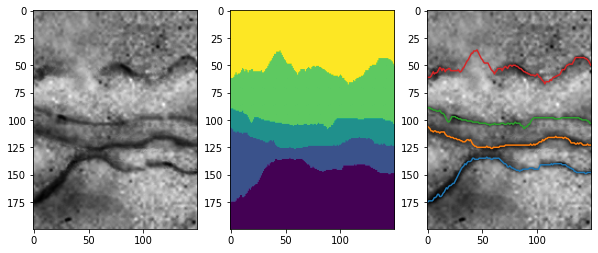

In [ ]:
segmentations = [helper.what_segments(l).astype(np.int32) for l in layers]
segmentation_lines = [s.sum(axis=0) - 1 for s in segmentations]

# Draw results.
plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 3, 1)
ax.imshow(image, cmap='gray')
ax = plt.subplot(1, 3, 2)
ax.imshow(np.sum(segmentations, axis=0))
ax = plt.subplot(1, 3, 3)
ax.imshow(image, cmap='gray')
for line in segmentation_lines:
    ax.plot(line)
plt.show()

## Detect surfaces in 3D
Until now we segmented 2D images, but the `slgbuilder` module actually supports N-D data. If `data` was a 3D `ndarray` the code would still work 'as is'. The surfaces are always found on the first axis of the input data.

As an example lets create a small volume from the same data as before and segment it.

Volume shape: (200, 150, 5)


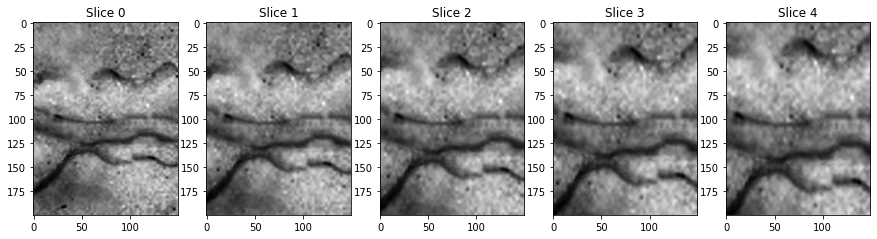

In [ ]:
# Create volume from data, by zooming-in the image.
import skimage.transform

dim = image.shape
nr_slices = 5 
slices = [skimage.transform.resize(image, (dim[0]+30*i, dim[1]+10*i), preserve_range=True)
        [15*i:None if i==0 else -15*i, 5*i:None if i==0 else -5*i] for i in range(nr_slices)]

volume = np.stack(slices, axis=2).astype(image.dtype)
print('Volume shape:', volume.shape)

plt.figure(figsize=(15, 10))
for i in range(nr_slices):
  ax = plt.subplot(1, nr_slices, i+1, title=f'Slice {i}')
  ax.imshow(volume[..., i], cmap='gray')
plt.show()

In [ ]:
layers = []
for i in range(4):
    layers.append(GraphObject(volume))
    
helper = MaxflowBuilder()
helper.add_objects(layers)
helper.add_layered_boundary_cost()
helper.add_layered_smoothness(delta=[[1, 12], [1, 12], [1, 12], [1, 12]], wrap=False)  

for i in range(len(layers)-1):
    helper.add_layered_containment(layers[i], layers[i+1], min_margin=10)

In [ ]:
flow = helper.solve()
print('Maximum flow/minimum energy:', flow)

Maximum flow/minimum energy: 1777916


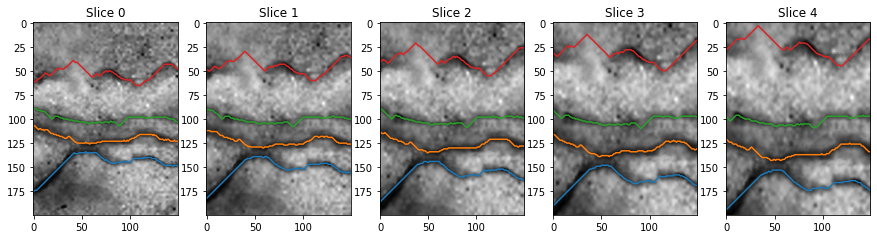

In [ ]:
segmentations = [helper.what_segments(l).astype(np.int32) for l in layers]
surface_lists = [s.sum(axis=0) - 1 for s in segmentations]
surfaces = np.array(surface_lists)

# Draw results.
plt.figure(figsize=(15, 10))
for i in range(nr_slices):
  ax = plt.subplot(1, nr_slices, i+1, title=f'Slice {i}')
  ax.imshow(volume[..., i], cmap='gray')
  for k in range(len(surfaces)):
      ax.plot(surfaces[k, :, i])
plt.show()



Showing the surfaces in 3D.

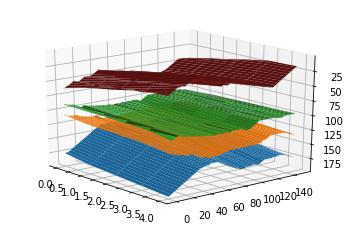

In [ ]:
x, y = np.meshgrid(np.arange(surfaces.shape[2]), np.arange(surfaces.shape[1]))
fig = plt.figure()
ax = plt.axes(projection ='3d')
for s in surfaces:
  ax.plot_surface(x, y, s)
ax.invert_zaxis()
ax.view_init(20, -40)
plt.show()

The segmentation is similar as before for each slice, as we applied only small change to the slices when creating the volume. The flow is now appproximattely four times larger, as we stacked up four images. Segmentation time and graph size have naturally also increased.

## In-region cost

In-region cost is suitable for segmentation problems where it is easier to describe the appearence of the segmentation regions (between surfaces) than segmentation lines. For example, if the lines are blurry as in the example below.

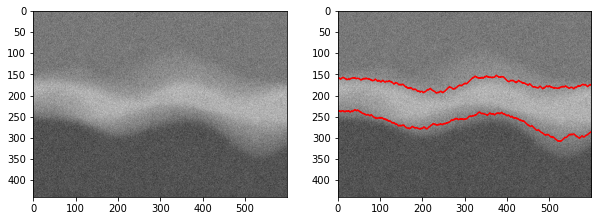

In [ ]:
url = 'https://qim.compute.dtu.dk/data-repository/demo_data/peaks_image.png'
image = skimage.io.imread(url).astype(np.int32)

layers = [GraphObject(0*image), GraphObject(0*image)] # no on-surface cost
helper = MaxflowBuilder()
helper.add_objects(layers)

# Adding regional costs, estimating region intensities to 100, 150, 120.
helper.add_layered_region_cost(layers[0], (image-100)**2, (image-150)**2)
helper.add_layered_region_cost(layers[1], (image-150)**2, (image-120)**2)

# Adding geometric constrains
helper.add_layered_boundary_cost()
helper.add_layered_smoothness(delta=1, wrap=False)  
helper.add_layered_containment(layers[0], layers[1], min_margin=1)

# Cut
helper.solve()
segmentations = [helper.what_segments(l).astype(np.int32) for l in layers]
segmentation_lines = [s.sum(axis=0) - 1 for s in segmentations]

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(image, cmap='gray')
ax[1].imshow(image, cmap='gray')
for line in segmentation_lines:
    ax[1].plot(line, 'r')
plt.show()

## Segmenting layers in limestone

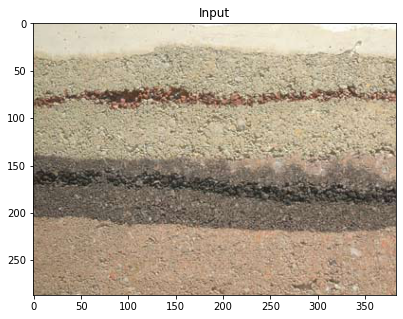

In [ ]:
url = 'https://qim.compute.dtu.dk/data-repository/demo_data/rammed-earth-layers-limestone.jpg'
RGB = skimage.io.imread(url).astype(np.int32)

# SETTINGS FOR GEOMETRIC CONSTRAINS
delta = 1 # smoothness very constrained, try also 3 to see less smoothness
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(RGB)
ax.set_title('Input')
plt.show()

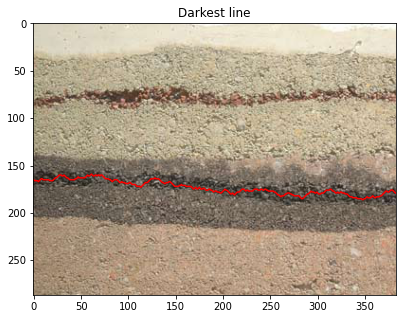

In [ ]:
# DARKEST LINE
I = np.mean(RGB, axis=2)
layer = GraphObject(I)
helper = MaxflowBuilder()
helper.add_object(layer)
helper.add_layered_boundary_cost()
helper.add_layered_smoothness(delta=delta, wrap=False)

helper.solve()
segmentation = helper.what_segments(layer)
segmentation_line = segmentation.sum(axis=0) - 1

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(RGB)
ax.plot(segmentation_line, 'r')
ax.set_title('Darkest line')
plt.show()

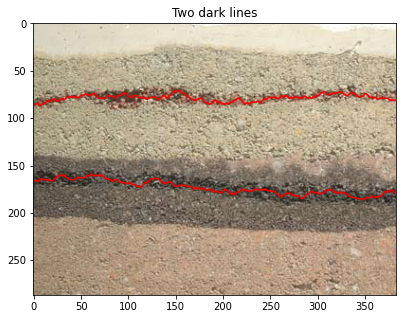

In [ ]:
# TWO DARK LINES
layers = [GraphObject(I), GraphObject(I)]
helper = MaxflowBuilder()
helper.add_objects(layers)
helper.add_layered_boundary_cost()
helper.add_layered_smoothness(delta=delta, wrap=False)
helper.add_layered_containment(layers[0], layers[1], min_margin=50, max_margin=200)

helper.solve()
segmentations = [helper.what_segments(l).astype(np.int32) for l in layers]
segmentation_lines = [s.sum(axis=0) - 1 for s in segmentations]

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(RGB)
for line in segmentation_lines:
    ax.plot(line, 'r')
ax.set_title('Two dark lines')
plt.show()

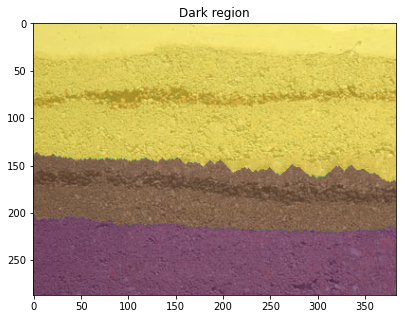

In [ ]:
# DARKEST REGION
layers = [GraphObject(0*I), GraphObject(0*I)] # no on-surface cost
helper = MaxflowBuilder()
helper.add_objects(layers)
helper.add_layered_boundary_cost()
helper.add_layered_region_cost(layers[0], 255-I, I)
helper.add_layered_region_cost(layers[1], I, 255-I)
helper.add_layered_smoothness(delta=delta, wrap=False)  
helper.add_layered_containment(layers[0], layers[1], min_margin=1, max_margin=200)

helper.solve()
segmentations = [helper.what_segments(l).astype(np.int32) for l in layers]

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(RGB)
for s in segmentations:
  ax.imshow(s, alpha=0.3)
ax.set_title('Dark region')
plt.show()